Neural net for predicting fraudulent transactions using Kaggle Fraudulent Transactions Data (https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data?resource=download).

Importing necessary librarys.

Historic versions

In [124]:
hyperparameters = pd.DataFrame([[1,"Initial","binary_crossentropy",0.01,"RMSprop",20,256,0.2]],
                                columns=['iter','comment','loss','learning_rate','optimizer','epochs','batch_size', 'validation_split'])

metrics = pd.DataFrame([test_scores],
                        columns=['loss','root_mean_squared_error','recall','precision','AUC'])


In [126]:
hyperparameters
metrics

,loss,root_mean_squared_error,recall,precision,AUC
0,0.004542,0.026678,0.412963,0.915185,0.618472


In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import scipy as sp
import seaborn as sns

Downloading data

In [3]:
df=pd.read_csv('C:/Users/T440s/Kaggle/archive/fraudulent_transaction_data.csv')

Getting to know the data set.

In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
'Number of cases where transaction originator is not Customer: {}'.format(len(df[df["nameOrig"].str.get(0) != "C"]))

'Number of cases where transaction originator is not Customer: 0'

Dataset doesn't have any missing data fields. Balance is missing for Merchant type persons. Merchants only on the Dest side.

Let's use this plot from the internet to illustrate how a model is performing.

In [76]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

### Feature engineering

Next up, we'll be adding additional parameters to our model, but for that we have to change them a little bit.

##### `step`
We will leave this out for now, as it seems to be a strong but not most realistic predictor (most of the fraud takes place in low steps.

##### `type`
This categorical value needs to be formated to use in the model. We'll use one hot encoding.

##### `amount`
As we now have other attributes in the model, `amount` should be normalised.

##### `nameOrig`
We'll discard this for now.

##### `oldbalanceOrg`
Will rename it to  `oldbalanceOrig` and normalize.

##### `newbalanceOrig`
Have to normalize this.

##### `nameDest`
We'll discard this for now, but calculate new features `customerDest` (1 if C) and `merchantDest` (1 if M).

##### `oldbalanceDest`
Have to normalize this. As the balance is 0 for all merchants, as it is unknown, other substitutes should be considered.

##### `newbalanceDest`
Have to normalize this. As the balance is 0 for all merchants, as it is unknown, other substitutes should be considered.


Will use `isFraud` as the label.

In [47]:
X = df[["type","amount","oldbalanceOrg","newbalanceOrig","nameDest","oldbalanceDest","newbalanceDest"]]
X = X.rename(columns={"oldbalanceOrg": "oldbalanceOrig"})
X["customerDest"] = (X["nameDest"].str.get(0) == "C").astype(float)
X["merchantDest"] = (X["nameDest"].str.get(0) == "M").astype(float)
X = X.drop(columns=["nameDest"])
y = df[["isFraud"]]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
columns = np.array(X_train.columns)
features_to_scale = ["amount","oldbalanceOrig","newbalanceOrig","oldbalanceDest","newbalanceDest"]

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features_to_scale),
        ('OHE', OneHotEncoder(sparse_output=False), ["type"]),
        ('passthrough', 'passthrough', ["customerDest", "merchantDest"])
    ],
    remainder='drop'  # Drop any columns not explicitly specified
).set_output(transform="pandas")

# Fit the ColumnTransformer and transform the data
X_train_transformed = preprocessor.fit_transform(X_train)

In [89]:
print('X_train_transformed: {}'.format(X_train_transformed.shape))
X_train_transformed.head()

X_train_transformed: (5090096, 12)


,scaler__amount,scaler__oldbalanceOrig,scaler__newbalanceOrig,scaler__oldbalanceDest,scaler__newbalanceDest,OHE__type_CASH_IN,OHE__type_CASH_OUT,OHE__type_DEBIT,OHE__type_PAYMENT,OHE__type_TRANSFER,passthrough__customerDest,passthrough__merchantDest
6271196,0.343453,1.328802,1.437536,-0.174992,-0.301147,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1888243,0.054355,-0.207401,-0.139419,-0.086546,-0.171883,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5549957,-0.265601,-0.287416,-0.292395,-0.324181,-0.333782,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2025342,0.578206,-0.226251,-0.292395,-0.297011,-0.164739,0.0,1.0,0.0,0.0,0.0,1.0,0.0
682342,0.043732,-0.288675,-0.292395,0.304224,0.303786,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [90]:
X_train_transformed.describe()

,scaler__amount,scaler__oldbalanceOrig,scaler__newbalanceOrig,scaler__oldbalanceDest,scaler__newbalanceDest,OHE__type_CASH_IN,OHE__type_CASH_OUT,OHE__type_DEBIT,OHE__type_PAYMENT,OHE__type_TRANSFER,passthrough__customerDest,passthrough__merchantDest
count,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06
mean,1.171885e-17,3.435367e-16,-6.574246e-17,-7.196587e-16,1.418490e-16,2.198748e-01,3.517788e-01,6.520899e-03,3.380478e-01,8.377759e-02,6.619522e-01,3.380478e-01
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.141617e-01,4.775254e-01,8.048837e-02,4.730450e-01,2.770540e-01,4.730450e-01,4.730450e-01
min,-2.987904e-01,-2.886750e-01,-2.923954e-01,-3.241808e-01,-3.337815e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-2.765242e-01,-2.886750e-01,-2.923954e-01,-3.241808e-01,-3.337815e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,-1.743509e-01,-2.837629e-01,-2.923954e-01,-2.850611e-01,-2.752718e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,4.801567e-02,-2.515057e-01,-2.430638e-01,-4.653224e-02,-3.075325e-02,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,1.533627e+02,2.035079e+01,1.667349e+01,1.046361e+02,9.681375e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


As we can see, there are still some very large values in the data set, that need some further exploration.

Defining simple model using just one layer.

In [91]:
inputs = tf.keras.Input(shape=(X_train_transformed.shape[1],))

In [92]:
dense = tf.keras.layers.Dense(1,activation = 'sigmoid')

In [93]:
outputs = dense(inputs)

In [94]:
simple_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="simple_model")

In [95]:
simple_model.summary()

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:
simple_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(reduction="sum_over_batch_size", name="binary_crossentropy"),
    #tf.keras.losses.MeanSquaredError(reduction="sum_over_batch_size", name="mean_squared_error"),#mean_squared_error
    optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.01),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.AUC(curve="PR",name="AUC")]#[tf.keras.metrics.SparseCategoricalAccuracy()],
)

Running the model for 20 epochs.

In [97]:
history = simple_model.fit(X_train_transformed, y_train, batch_size=256, epochs=20, validation_split=0.2)

Epoch 1/20
15907/15907 [==============================] - 36s 2ms/step - loss: 0.0072 - root_mean_squared_error: 0.0351 - recall: 0.2318 - precision: 0.7627 - AUC: 0.2735 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0288 - val_recall: 0.2950 - val_precision: 0.9871 - val_AUC: 0.5369
Epoch 2/20
15907/15907 [==============================] - 31s 2ms/step - loss: 0.0049 - root_mean_squared_error: 0.0285 - recall: 0.3360 - precision: 0.9648 - AUC: 0.5499 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0278 - val_recall: 0.3529 - val_precision: 0.9541 - val_AUC: 0.5601
Epoch 3/20
15907/15907 [==============================] - 33s 2ms/step - loss: 0.0046 - root_mean_squared_error: 0.0279 - recall: 0.3650 - precision: 0.9466 - AUC: 0.5731 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0273 - val_recall: 0.3876 - val_precision: 0.9383 - val_AUC: 0.5802
Epoch 4/20
15907/15907 [==============================] - 33s 2ms/step - loss: 0.0045 - root_mean_squared_error: 0.0275 - recal

Lets see how the model is performing based on the defined metrics.

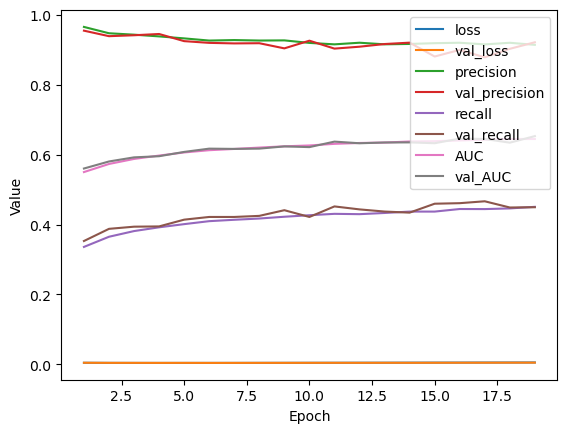

In [99]:
list_of_metrics_to_plot = ['loss','val_loss','precision','val_precision','recall','val_recall','AUC','val_AUC']
plot_curve(history.epoch, pd.DataFrame(history.history), list_of_metrics_to_plot)

In [100]:
X_test_transformed = preprocessor.transform(X_test)
X_test_transformed.head()

,scaler__amount,scaler__oldbalanceOrig,scaler__newbalanceOrig,scaler__oldbalanceDest,scaler__newbalanceDest,OHE__type_CASH_IN,OHE__type_CASH_OUT,OHE__type_DEBIT,OHE__type_PAYMENT,OHE__type_TRANSFER,passthrough__customerDest,passthrough__merchantDest
3737323,0.250094,-0.281447,-0.172269,-0.190799,-0.300451,1.0,0.0,0.0,0.0,0.0,1.0,0.0
264914,-0.279431,-0.278155,-0.285989,-0.324181,-0.333782,0.0,0.0,0.0,1.0,0.0,0.0,1.0
85647,-0.045699,-0.251754,-0.203827,-0.264833,-0.320406,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5899326,2.280522,-0.288675,-0.292395,0.618756,0.961809,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2544263,-0.168854,0.723236,0.733907,-0.201589,-0.241688,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [78]:
test_scores = simple_model.evaluate(X_test_transformed, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test root mean squared error:", test_scores[1])

39767/39767 - 49s - loss: 0.0045 - root_mean_squared_error: 0.0267 - recall: 0.4130 - precision: 0.9152 - AUC: 0.6185 - 49s/epoch - 1ms/step
Test loss: 0.004541558679193258
Test root mean squared error: 0.02667786367237568


In [81]:
test_predictions = simple_model.predict(X_test_transformed)

39767/39767 [==============================] - 46s 1ms/step


In [105]:
test_predictions

array([[8.0811958e-07],
       [7.6610195e-06],
       [1.8167446e-05],
       ...,
       [3.9422521e-04],
       [2.6370806e-04],
       [4.0535851e-05]], dtype=float32)

Legitimate Transactions Detected (True Negatives):  1270842
Legitimate Transactions Incorrectly Detected (False Positives):  62
Fraudulent Transactions Missed (False Negatives):  951
Fraudulent Transactions Detected (True Positives):  669
Total Fraudulent Transactions:  1620


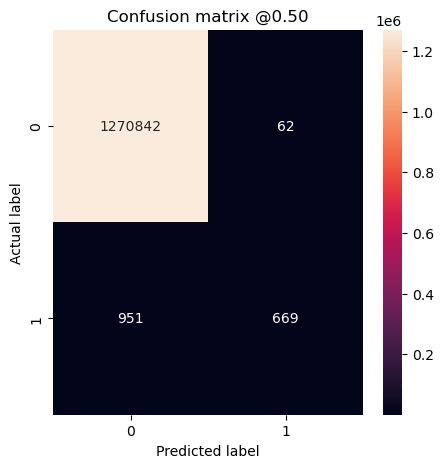

In [109]:
plot_cm(y_test, test_predictions)

In this case the model is already performing better, but the recall is too low. As in our case the cost of false negative is much higher than false positive, something should be done in that regard. Options to try would be undersampling negative examples and using weighed loss.